<a href="https://colab.research.google.com/github/yoonjong8739/NLP_study/blob/master/_9_1_CNN_%EC%8A%A4%ED%8C%B8_%EB%A9%94%EC%9D%BC_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CNN 스팸 메일 분류

### 데이터 로드 및 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

* https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv",
                           filename='spam.csv')

data = pd.read_csv('spam.csv', encoding='latin-1')  # 영어
print(len(data))

5572


In [ ]:
data.head(10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham', 'spam'], [0, 1])  # 0:정상, 1:스팸
data.head(10)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
5,1,FreeMsg Hey there darling it's been 3 week's n...
6,0,Even my brother is not like to speak with me. ...
7,0,As per your request 'Melle Melle (Oru Minnamin...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...


In [ ]:
data.drop_duplicates(subset=['v2'], inplace=True)
len(data)

5169

<Axes: >

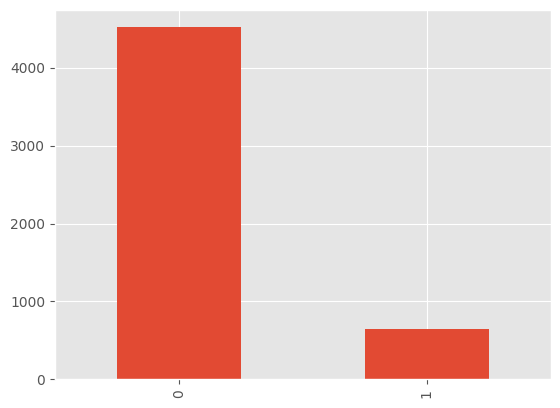

In [ ]:
data['v1'].value_counts().plot(kind='bar')

In [ ]:
data.groupby('v1').size().reset_index(name='count')

,v1,count
0,0,4516
1,1,653


In [ ]:
X_data = data['v2']
y_data = data['v1']

In [ ]:
vocab_size = 1000
tokenizer = Tokenizer(num_words = vocab_size)  # 빈도가 높은 단어 선택하도록 객체 생성
tokenizer.fit_on_texts(X_data)  # 단어 인덱스 구축
sequences = tokenizer.texts_to_sequences(X_data)  # 만들어진 단어 인덱스를 이용해 문서들을 변환

In [ ]:
sequences[:2]

[[47, 433, 780, 705, 662, 64, 8, 94, 121, 434, 142, 68, 57, 137],
 [49, 306, 435, 6]]

In [ ]:
X_data = sequences

print('메일 최대 길이 : {}'.format(max(len(l) for l in X_data )))
print('메일 평균 길이 : {}'.format( (sum(map(len, X_data)) / len(X_data)) ))

메일 최대 길이 : 172
메일 평균 길이 : 12.566840781582512


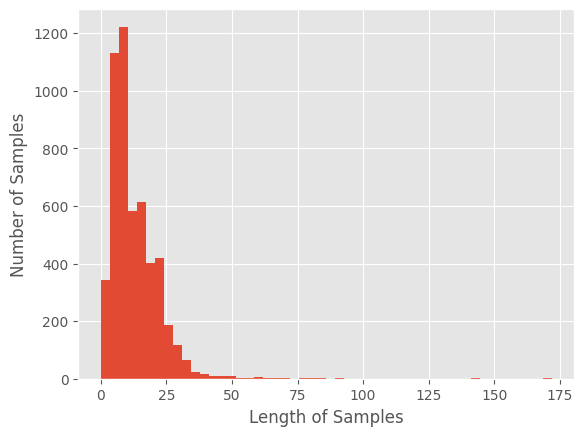

In [ ]:
plt.hist([ len(s) for s in X_data ], bins = 50)

plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show();

In [ ]:
# sequences의 길이가 제각각이므로 pad_sequences()로 길이를 맞춘다.
max_len = 60
data = pad_sequences(X_data, maxlen=max_len)  # padding = 'pre'
print(data.shape)

(5169, 60)


In [ ]:
n_train = int(len(X_data) * 0.8)
n_test = int(len(X_data) - n_train)

print('훈련 데이터 개수 : ', n_train)
print('테스트 데이터 개수 : ', n_test)

훈련 데이터 개수 :  4135
테스트 데이터 개수 :  1034


In [ ]:
X_train = data[:n_train]
y_train = np.array(y_data[:n_train])
X_test = data[n_train:]
y_test = np.array(y_data[n_train:])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4135, 60)
(4135,)
(1034, 60)
(1034,)


### 모델 구성

In [ ]:
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout, MaxPooling1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())  # 여러 개의 벡터 정보 중 가장 큰 벡터를 골라서 반환합니다.
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          32000     
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 32)          5152      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

### 모델 학습

In [ ]:
history = model.fit(
    X_train, y_train, epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, mc]
)

Epoch 1/10
52/52 [==============================] - ETA: 0s - loss: 0.4521 - acc: 0.8697
Epoch 1: val_acc improved from -inf to 0.87304, saving model to best_model.h5
52/52 [==============================] - 19s 158ms/step - loss: 0.4521 - acc: 0.8697 - val_loss: 0.3832 - val_acc: 0.8730
Epoch 2/10
52/52 [==============================] - ETA: 0s - loss: 0.3658 - acc: 0.8697
Epoch 2: val_acc did not improve from 0.87304
52/52 [==============================] - 6s 105ms/step - loss: 0.3658 - acc: 0.8697 - val_loss: 0.3149 - val_acc: 0.8730
Epoch 3/10
49/52 [===========================>..] - ETA: 0s - loss: 0.1867 - acc: 0.9212
Epoch 3: val_acc improved from 0.87304 to 0.97944, saving model to best_model.h5
52/52 [==============================] - 2s 45ms/step - loss: 0.1808 - acc: 0.9247 - val_loss: 0.0843 - val_acc: 0.9794
Epoch 4/10
52/52 [==============================] - ETA: 0s - loss: 0.0595 - acc: 0.9837
Epoch 4: val_acc improved from 0.97944 to 0.98307, saving model to best_mode

### 시각화

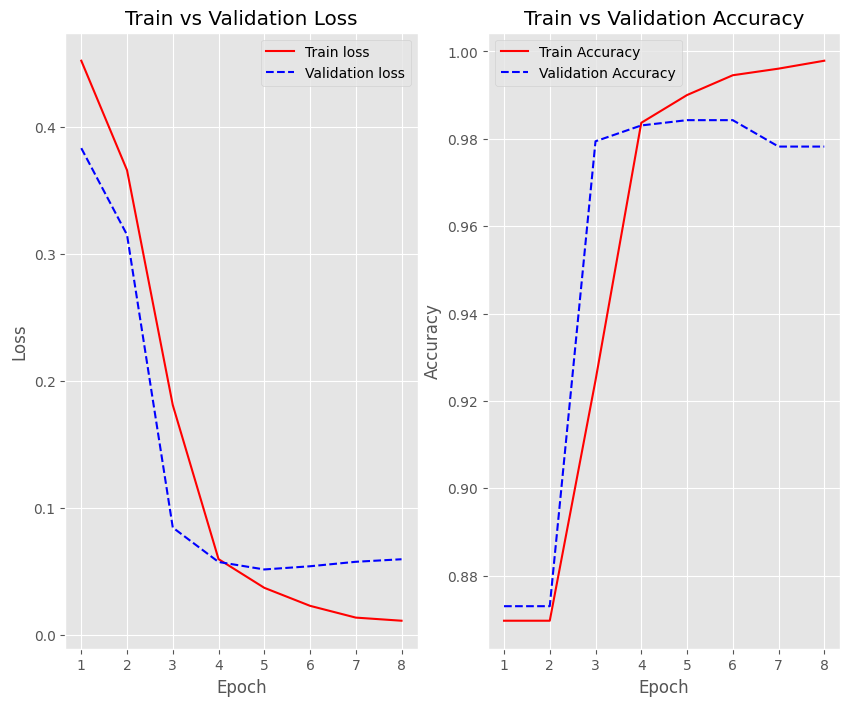

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'r', label='Train loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation Accuracy')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show();

In [ ]:
model.evaluate(X_test, y_test)

33/33 [==============================] - 0s 7ms/step - loss: 0.0587 - acc: 0.9836


[0.05872265622019768, 0.9835590124130249]

In [ ]:
pred = model.predict(X_test)
pred

33/33 [==============================] - 0s 4ms/step


array([[0.00273359],
       [0.00438201],
       [0.04196196],
       ...,
       [0.00243724],
       [0.00339981],
       [0.00119518]], dtype=float32)

In [ ]:
for p in pred:
    percent = p[0]
    if percent > 0.5 :
        print("{:.3f}% 확률로 스팸 메일입니다.\n".format( ( percent) ))
    else:
        print("{:.3f}% 확률로 정상 메일입니다.\n".format( 1-percent ))

0.997% 확률로 정상 메일입니다.

0.996% 확률로 정상 메일입니다.

0.958% 확률로 정상 메일입니다.

0.960% 확률로 정상 메일입니다.

0.943% 확률로 정상 메일입니다.

0.998% 확률로 정상 메일입니다.

0.998% 확률로 정상 메일입니다.

0.998% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.978% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.986% 확률로 정상 메일입니다.

0.989% 확률로 스팸 메일입니다.

0.999% 확률로 정상 메일입니다.

0.985% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.998% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.991% 확률로 정상 메일입니다.

0.998% 확률로 정상 메일입니다.

0.987% 확률로 정상 메일입니다.

0.997% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.995% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.981% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.998% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.974% 확률로 스팸 메일입니다.

0.998% 확률로 정상 메일입니다.

0.973% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

1.000% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.997% 확률로 정상 메일입니다.

0.992% 확률로 정상 메일입니다.

0.995% 확률로 정상 메일입니다.

0.999% 확률로 정상 메일입니다.

0.995% 확률로